# A Consumer's Guide to Review Aggregators

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import re
from collections import Counter

import scipy.stats
import seaborn as sns

# Rotten Tomatoes Analysis

Rotten Tomatoes data sourced from https://www.kaggle.com/datasets/andrezaza/clapper-massive-rotten-tomatoes-movies-and-reviews

In [2]:
#Importing movie, and review tables

rotten_tomatoes_movies = pd.read_csv('rotten_tomatoes_movies.csv')
rotten_tomatoes_reviews = pd.read_csv('rotten_tomatoes_movie_reviews.csv')

print(rotten_tomatoes_movies.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143258 entries, 0 to 143257
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    143258 non-null  object 
 1   title                 142891 non-null  object 
 2   audienceScore         73248 non-null   float64
 3   tomatoMeter           33877 non-null   float64
 4   rating                13991 non-null   object 
 5   ratingContents        13991 non-null   object 
 6   releaseDateTheaters   30773 non-null   object 
 7   releaseDateStreaming  79420 non-null   object 
 8   runtimeMinutes        129431 non-null  float64
 9   genre                 132175 non-null  object 
 10  originalLanguage      129400 non-null  object 
 11  director              139064 non-null  object 
 12  writer                90116 non-null   object 
 13  boxOffice             14743 non-null   object 
 14  distributor           23005 non-null   object 
 15  

### Getting the range of dates for these movies

In [4]:
rotten_tomatoes_dates = rotten_tomatoes_movies['releaseDateTheaters']
rotten_tomatoes_dates = rotten_tomatoes_dates[~rotten_tomatoes_dates.isna()]
print('Rotten Tomatoes earliest: ', min(rotten_tomatoes_dates))
print('Rotten Tomatoes latest: ', max(rotten_tomatoes_dates))

Rotten Tomatoes earliest:  1902-10-04
Rotten Tomatoes latest:  2032-04-21


The Rotten Tomatoes movies release dates range from 1902 to projected release.

We need to do some preparatory cleaning. The box office totals are stored as strings like "\$5.4M" or "\$390K" meaning \$5,400,000 or \$390,000, respectively. We first convert these strings to numeric values.

In [5]:
# Input: A string formatted like '$32.4K' or '$5.3M'
# Returns: The input amount as a float, like 32,400 or 5,300,000. 
# Exception: Returns NaN if input not a string or not formatted in this manner
def currency_to_number(currency):
    if type(currency) != str:
        return np.nan
    if bool(re.match(r'\$.*M', currency)):
        return 1000000*float(currency[1:-1])
    elif bool(re.match(r'\$.*K', currency)):
        return 1000*float(currency[1:-1])
    return np.nan
    
rotten_tomatoes_movies['boxOfficeGross'] = rotten_tomatoes_movies['boxOffice'].apply(currency_to_number)

We begin our analysis with some helper functions. One to turn numeric ratings into floating point numbers from 0 to 1, and another to get the cumulative distribution function of a collection of data.

In [6]:
# Input: A string representing a rating like 
# '2/5' or '7 out of 10'.
# Returns: The value of a rating as a float between 0-1
# like 0.4 and 0.7 in the examples. 
# EXCEPTION: NaN on Value Error or Division by Zero error
def rating_process(rating_string):
    if type(rating_string) != str:
        return np.nan
    test_string = str.lower(rating_string)
    test_string = ''.join(test_string.split())
    scores = re.split(r'/|outof', test_string)
    if len(scores) != 2:
        return np.nan
    try:
        values = [float(scores[0]), float(scores[1])]
        score = 100*min(values)/max(values)
        return score
    except (ValueError, ZeroDivisionError):
        return np.nan
    
# INPUT: An array of numerical data
# RETURN: The empirical cumulative distribution function of that data
#         as an ordered pair of arrays
#         (sorted distinct values, quantiles of those values)
# EXCEPTION: TypeError if input is neither a list nor numpy array
def ecdf(data):
    if not isinstance(data, (list, np.ndarray, pd.Series)):
        raise TypeError('Data needs to be a numeric list or array.')
    N = len(data)
    result = pd.value_counts(data).reset_index()
    result.rename(columns={result.columns[0], result.columns[1] : 'counts'}, inplace=True)
    result.sort_values('values', inplace=True)
    result['quantiles'] = result['counts'].cumsum()/N
    return result[['values', 'quantiles']]


Let's look at Rotten Tomatoes data and try to both predict and analyze the relationships between the key pieces of performance data we have access to: Box office gross, the Tomato meter, average critic score, and average audience score.  

One of the metrics Rotten Tomatoes uses in determining both if a movie gets a tomatometer at all and if it gets the marker "Certified Fresh" is through review count. Depending on projected box office earnings, movies need either 10, 20, or 40 reviews to get a Tomato meter. Part of being certified fresh is that a movie needs either 40 or 80 reviews depending on the scale of release, and it needs at least 5 reviews from top critics.

A natural question to ask then is how restrictive are these requirements? Namely what proportion of movies meet these various requirements? We also ask what proportion of movies have any reviews at all.

In [7]:
movies_to_reviews = rotten_tomatoes_movies[['id']].merge(rotten_tomatoes_reviews, how='left', on='id')

#Getting total review counts 
review_counts_by_movie = movies_to_reviews.groupby('id')[['reviewId', 'isTopCritic']].agg({'reviewId' : 'count', 'isTopCritic' : 'sum'}).reset_index()
review_counts_by_movie.rename(columns={'reviewId' : 'totalCountReviews', 'isTopCritic' : 'countTopCriticReviews'}, inplace=True)

review_thresholds = np.array([1, 10, 20, 40, 80])
review_quantiles = []
for threshold in review_thresholds:
    movies_at_threshold = review_counts_by_movie['totalCountReviews'] >= threshold
    proprtion_at_threshold = np.round(np.mean(movies_at_threshold), 2)
    # string_proportion = str(int(100*proprtion_at_threshold)) + '%'
    review_quantiles.append(proprtion_at_threshold)

top_review_thresholds = np.array([1, 5, 10])
top_review_quantiles = []
for threshold in top_review_thresholds:
    movies_at_threshold = review_counts_by_movie['countTopCriticReviews'] >= threshold
    proprtion_at_threshold = np.round(np.mean(movies_at_threshold), 2)
    top_review_quantiles.append(proprtion_at_threshold)

review_proportions = pd.DataFrame({'Number of reviews' : review_thresholds, 'Proportion at least x reviews' : review_quantiles})
review_proportions

,Number of reviews,Proportion at least x reviews
0,1,0.49
1,10,0.16
2,20,0.11
3,40,0.07
4,80,0.04


In [8]:
top_review_proportions = pd.DataFrame({'Number of Top Critic Reviews' : top_review_thresholds, 'Proportion at least x top critic reviews' : top_review_quantiles})
top_review_proportions

,Number of Top Critic Reviews,Proportion at least x top critic reviews
0,1,0.29
1,5,0.13
2,10,0.09


So these requirements bring us down to roughly the top 10% of movies. We can get a better sense of these requirements by looking at the distribution functions of these variables

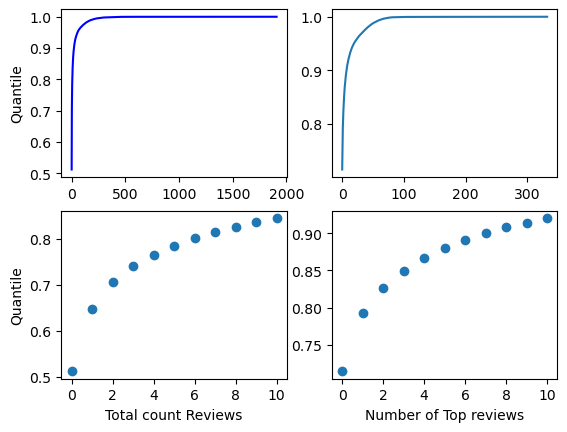

In [9]:
review_quantiles = ecdf(review_counts_by_movie['totalCountReviews'])

top_review_quantiles = ecdf(review_counts_by_movie['countTopCriticReviews'])

fig, ax = plt.subplots(2, 2)
ax[0, 0].plot(review_quantiles['values'], review_quantiles['quantiles'], color='blue')
ax[1, 0].set_xlabel('Total count Reviews')
ax[0, 0].set_ylabel('Quantile')
ax[0, 1].plot(top_review_quantiles['values'], top_review_quantiles['quantiles'])
ax[1, 1].set_xlabel('Number of Top reviews')

focus_reviews = review_quantiles[review_quantiles['values'] <= 10]
focus_top_reviews = top_review_quantiles[top_review_quantiles['values'] <= 10]

ax[1, 0].scatter(focus_reviews['values'], focus_reviews['quantiles'])
ax[1, 1].scatter(focus_top_reviews['values'], focus_top_reviews['quantiles'])
ax[1, 0].set_xticks(np.arange(0, 11, 2))
ax[1, 1].set_xticks(np.arange(0, 11, 2))
ax[1, 0].set_ylabel('Quantile')
plt.show()

The remaining variable left to build is average critic score, which takes a bit of pre-processing.

In [14]:
# Interpret each numeric review as a score 0-1

rotten_tomatoes_reviews['processedScore'] = rotten_tomatoes_reviews['originalScore'].apply(rating_process)

# For each movie, compute the count, average, and standard deviation of reviews. 

scores_by_movie = rotten_tomatoes_reviews.groupby('id')[[ 'processedScore']].mean().reset_index()
cols = scores_by_movie.columns
scores_by_movie.rename(columns={cols[0] : 'id',  cols[1] : 'avgReviews'}, inplace=True)

# Compute the count, average score, and standard deviation of scores 
# for reviews split by top critic vs. not top critic.

scores_by_movie_top_critic = rotten_tomatoes_reviews.groupby(['id', 'isTopCritic'])[['processedScore']].mean().reset_index()
scores_by_movie_top_critic.rename(columns={'processedScore' : 'avgReviewsByTopCritic'}, inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105368 entries, 0 to 105367
Data columns (total 3 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     105368 non-null  object 
 1   isTopCritic            105368 non-null  bool   
 2   avgReviewsByTopCritic  81989 non-null   float64
dtypes: bool(1), float64(1), object(1)
memory usage: 1.7+ MB
None


Now that we have a sense of review count and how sharply skewed left it is, we see if we can use review count or any of our other metrics to predict something meaningful about a movie's performance. Our main dependent variable is box office gross, but we can also use audience response since our other metrics don't take that into account.

In [15]:
variables_to_include = ['id', 'audienceScore', 'tomatoMeter', 'boxOfficeGross']
movies_with_review_counts = rotten_tomatoes_movies[variables_to_include].merge(review_counts_by_movie, on='id')

movies_with_review_counts.corr()**2



/var/folders/n6/vyd_h66168jcd7wwmwg1vylr0000gn/T/ipykernel_95010/1970252938.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  movies_with_review_counts.corr()**2


,audienceScore,tomatoMeter,boxOfficeGross,totalCountReviews
audienceScore,1.000000,0.362820,0.007829,0.022985
tomatoMeter,0.362820,1.000000,0.000030,0.000657
boxOfficeGross,0.007829,0.000030,1.000000,0.231530
totalCountReviews,0.022985,0.000657,0.231530,1.000000


We don't see any significant r^2 values among any of these traits individually, except slight signals for audience score and the tomato meter, along with total count of reviews and box office gross. We see if the certified fresh designation, which cuts out many movies and takes these statistics in combination, does any better.

In [16]:
movies_with_review_counts['enoughReviews'] = movies_with_review_counts['totalCountReviews'] >= 40
movies_with_review_counts['enoughTopCriticReviews'] = movies_with_review_counts['countTopCriticReviews'] >= 5
movies_with_review_counts['highTomato'] = movies_with_review_counts['tomatoMeter'] >= 0.75

movies_with_review_counts['certifiedFresh'] = np.all(movies_with_review_counts[['enoughReviews', 'enoughTopCriticReviews', 'highTomato']], axis=1)

movies_with_review_counts_and_scores = movies_with_review_counts.merge(scores_by_movie, on='id')

/var/folders/n6/vyd_h66168jcd7wwmwg1vylr0000gn/T/ipykernel_95010/3341205621.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_tick_labels)


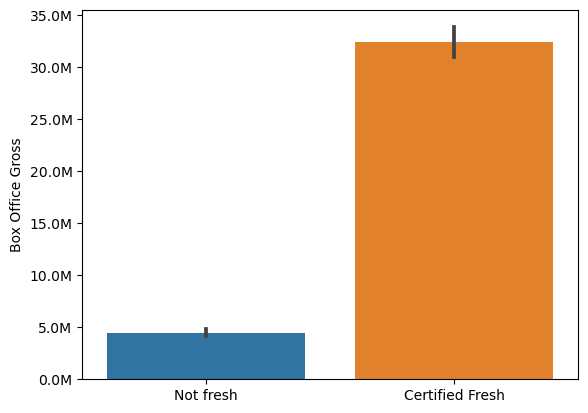

t-test results for  Box Office Gross
t-statistic:  36.55004454925616
p value:  1.2791420885803586e-270


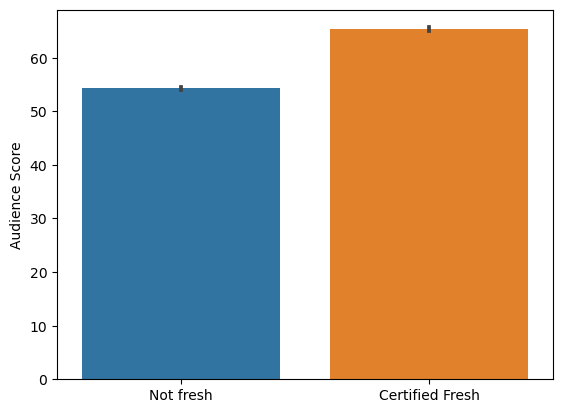

t-test results for  Audience Score
t-statistic:  49.53386399258611
p value:  0.0


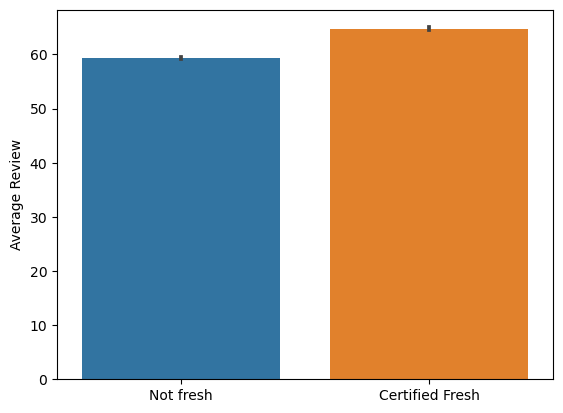

t-test results for  Average Review
t-statistic:  33.066190022343136
p value:  5.053452514839251e-232


In [17]:
fresh_variables = ['boxOfficeGross', 'audienceScore','avgReviews']
nice_names = ['Box Office Gross', 'Audience Score', 'Average Review']

for index, variable in enumerate(fresh_variables):
    source_table = movies_with_review_counts
    if 'Reviews' in variable:
        source_table = movies_with_review_counts_and_scores
    fresh_movies = source_table[source_table['certifiedFresh']]
    not_fresh_movies = source_table[~source_table['certifiedFresh']]
    
    fig, ax = plt.subplots()
    sns.barplot(data=source_table, x='certifiedFresh', y=variable, ax=ax)
    ax.set_xticklabels(['Not fresh', 'Certified Fresh'])
    ax.set_xlabel('')
    ax.set_ylabel(nice_names[index])
    if variable == 'boxOfficeGross':
        y_ticks = ax.get_yticks()/(10**6)
        y_tick_labels = ['{:.1f}M'.format(tick) for tick in y_ticks]
        ax.set_yticklabels(y_tick_labels)
    plt.show()


    print('t-test results for ', nice_names[index]) 
    t_test = scipy.stats.ttest_ind(fresh_movies[variable], not_fresh_movies[variable], equal_var=False, nan_policy='omit')
    print('t-statistic: ', t_test.statistic)
    print('p value: ', t_test.pvalue)

The certified fresh designation is associated with much high box office gross, and moderately higher audience ratings. The critic scores are marginally higher, though that has significant autocorrelation as critic scores go directly into making the tomato meter.

Now we are lead to the question of what part of the certified fresh designation is responsible for this prediction of box office power? Do review count, top critic review count, or the tomato meter carve out high earning movies most effectively?

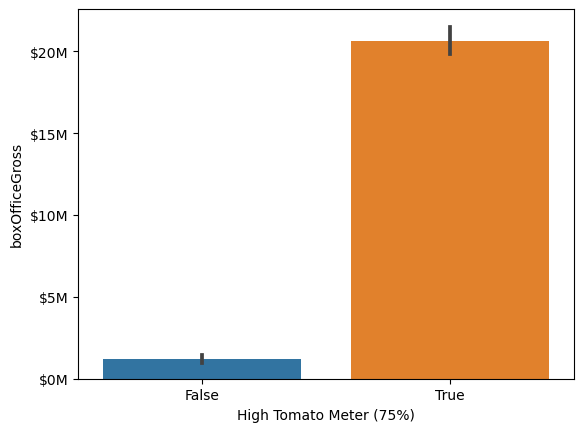

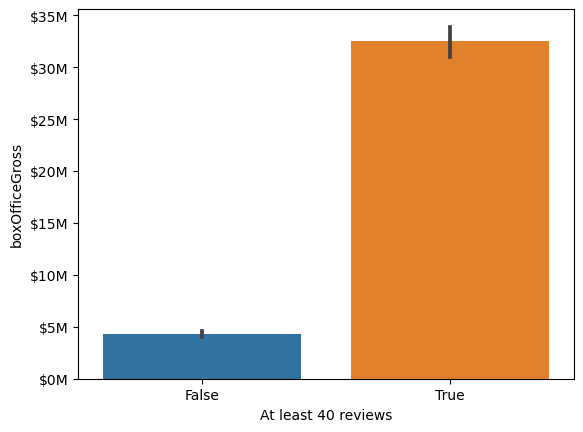

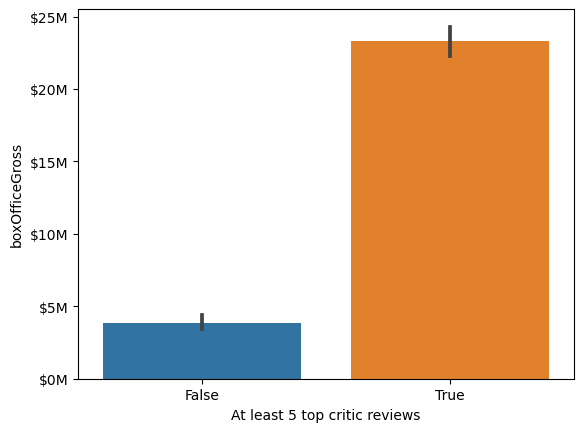

In [18]:
test_variables = ['highTomato', 'enoughReviews', 'enoughTopCriticReviews']
nice_names = ['High Tomato Meter (75%)', 'At least 40 reviews', 'At least 5 top critic reviews']

import matplotlib.ticker as ticker

for variable, nice_name in zip(test_variables, nice_names):
    fig, ax = plt.subplots()
    sns.barplot(data=movies_with_review_counts, x=variable, y='boxOfficeGross', ax=ax)
    ax.set_xlabel(nice_name)
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '${:,.0f}'.format(x/(10**6)) + 'M'))
    plt.show()

Here we see that filtering by review count is the most effective predictor, but all variables filter well for high box office earnings. 

As a final pass on this dataset, we adopt what might be a more obvious approach. Filter out movies with a low average critic score. Here we say high average is 75%. 

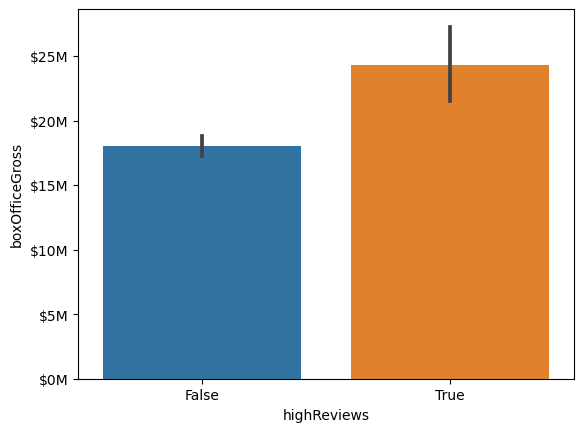

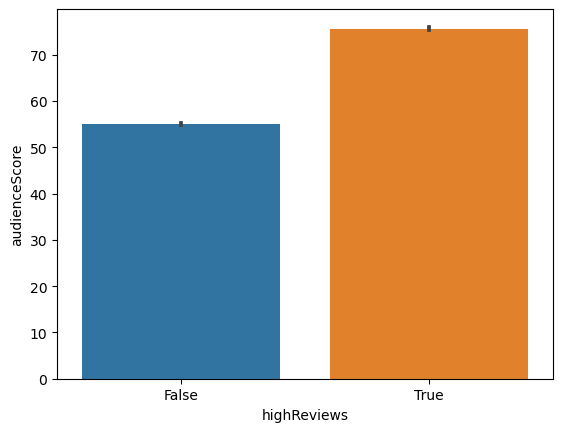

Ttest_indResult(statistic=4.054072247264157, pvalue=5.1798935398814966e-05)


In [19]:
movies_with_review_counts_and_scores['highReviews'] = movies_with_review_counts_and_scores['avgReviews'] >= 75

fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
sns.barplot(data=movies_with_review_counts_and_scores, x='highReviews', y='boxOfficeGross', ax = ax1)
sns.barplot(data=movies_with_review_counts_and_scores, x='highReviews', y='audienceScore', ax=ax2)
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '${:,.0f}'.format(x/(10**6)) + 'M'))
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '${:,.0f}'.format(x/(10**6)) + 'M'))
plt.show()

high_reviewed_movies = movies_with_review_counts_and_scores[movies_with_review_counts_and_scores['highReviews']]
low_reviewed_movies = movies_with_review_counts_and_scores[~movies_with_review_counts_and_scores['highReviews']]
print(scipy.stats.ttest_ind(high_reviewed_movies['boxOfficeGross'], low_reviewed_movies['boxOfficeGross'], equal_var=False, nan_policy='omit'))


Here we see that filtering for high critic scores does tend to yield higher audience scores and increased box office earnings, a sign that critics do have some connection to the general public. But the low correlation shows that it's not a perfect predictor.

# Metacritic Analysis 

Let's see if the same principles apply to another review aggregator and another medium. Inspired by the Rotten Tomatoes tomatometer, can we use metacritic scores combined with a high review count to find high earning video games?

To do this, we use a scrape of VGcharts which has sales data together with metacritic score and the number of metacritic reviews. Data sourced from https://www.kaggle.com/datasets/gregorut/videogamesales. 

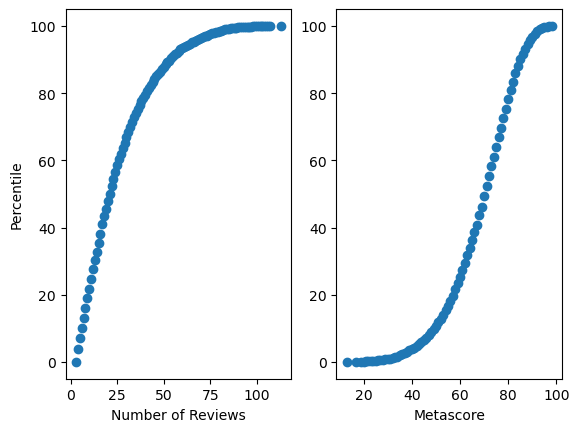

In [20]:
#Import sales data, filter out games without critic data
game_sales = pd.read_csv('video_game_sales.csv')

game_sales = game_sales[~game_sales['Critic_Count'].isna()]

critic_count_distribution = ecdf(game_sales['Critic_Count'])
critic_score_distribution = ecdf(game_sales['Critic_Score'])

ig, ax = plt.subplots(1, 2)
ax[0].scatter(critic_count_distribution['values'], 100*critic_count_distribution['quantiles'])
ax[0].set_xlabel('Number of Reviews')
ax[0].set_ylabel('Percentile')
ax[1].scatter(critic_score_distribution['values'], 100*critic_score_distribution['quantiles'])
ax[1].set_xlabel('Metascore')
ax[1].set_ylabel('')
plt.show()

Where do Rotten Tomato's thresholds of 40 and 80 reviews fit into this distribution?

In [21]:
critic_count_distribution[critic_count_distribution['values'].isin([40, 60, 80])]

,values,quantiles
42,40.0,0.794150
62,60.0,0.933636
78,80.0,0.984146


Let's see how effective the more conservative count of 40 reviews together with an average critic score of 75 is at detecting high selling games, and games with high user scores.

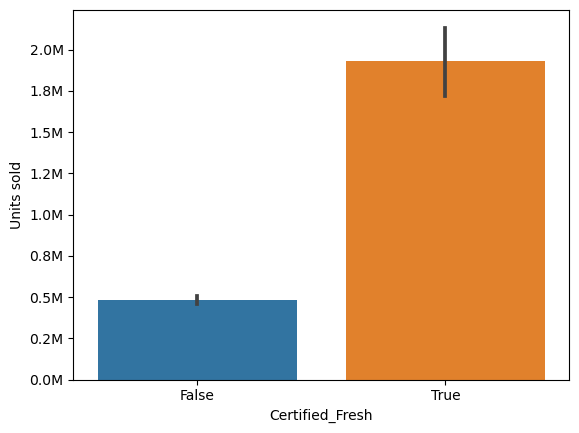

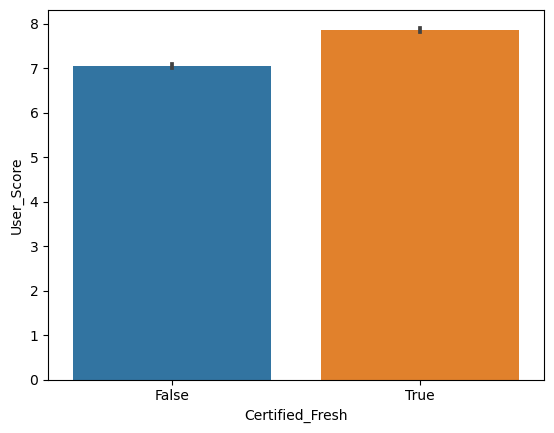

In [22]:
game_sales['Enough_Reviews'] = game_sales['Critic_Count'] >= 40
game_sales['High_Score'] = game_sales['Critic_Score'] >= 75

game_sales['Certified_Fresh'] = game_sales['Enough_Reviews'] & game_sales['High_Score']
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
sns.barplot(data=game_sales, x='Certified_Fresh', y='Global_Sales', ax=ax1)
ax1.set_ylabel('Units sold')
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.1f}'.format(x) + 'M'))
sns.barplot(data=game_sales, x='Certified_Fresh', y='User_Score', ax=ax2)
plt.show()

This version of the certified fresh criterion works surprisingly well at predicting game sales! It looks like Metacritic would be well served in implementing a similar feature. And we arrive at a reasonably solid strategy for consumers. If you want to find popular works of art, the combination of large number of positive reviews from trusted sources is a great tool. 